In [39]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

matplotlib.rcParams['figure.figsize'] = 9, 6
matplotlib.rcParams['legend.loc'] = 'best'

# We'll need these packages for plotting fit lines
import statsmodels.api as sm
from patsy import dmatrices


## CPU Percentage over time

We are curretly sampling the CPU % data at "2s" but you could change the `resample` value to any other value.

In [19]:
cpuData = pd.read_csv('cpuStats-2017-01-12T01-53-32Z.csv')
cpuData['timestamp'] = pd.to_datetime(cpuData['timestamp'].str.strip(' +0000 UTC'))
cpuResample = cpuData.set_index('timestamp').resample('5s')

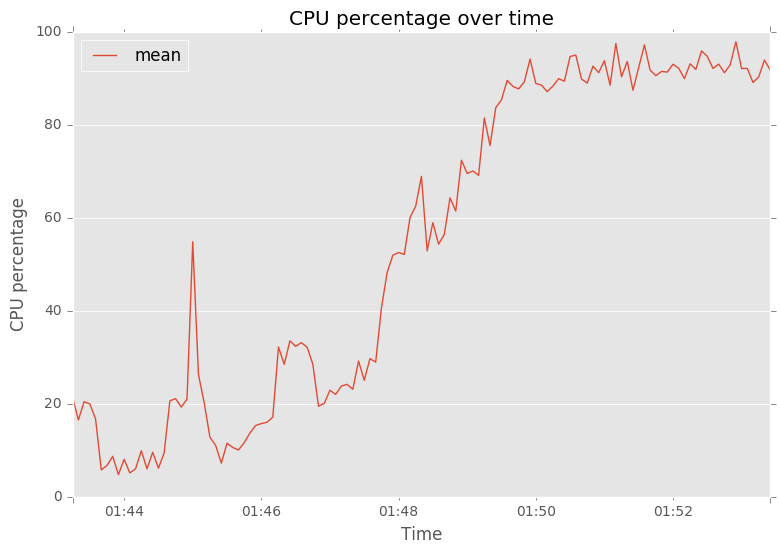

In [20]:
fig, ax = plt.subplots()
ax = cpuResample.mean().plot(ax=ax, kind='line',y='percentage')
ax.legend(['mean'])
ax.set_ylabel('CPU percentage')
ax.set_xlabel('Time')
ax.set_title('CPU percentage over time')
plt.show()

## Throughput Data over time

We see the spike's in below graph because of the way we are testing performance. Since it is a ramp up test throughput does not consistently increase over time. 

In [26]:
goData = pd.read_csv('2017-01-12T01-53-32Z.csv', parse_dates=['start-time'])

In [27]:
throughputBucket = goData.set_index('start-time')['response-time'].resample('1S')
throughputDataset = throughputBucket.aggregate({'throughput':'count'})


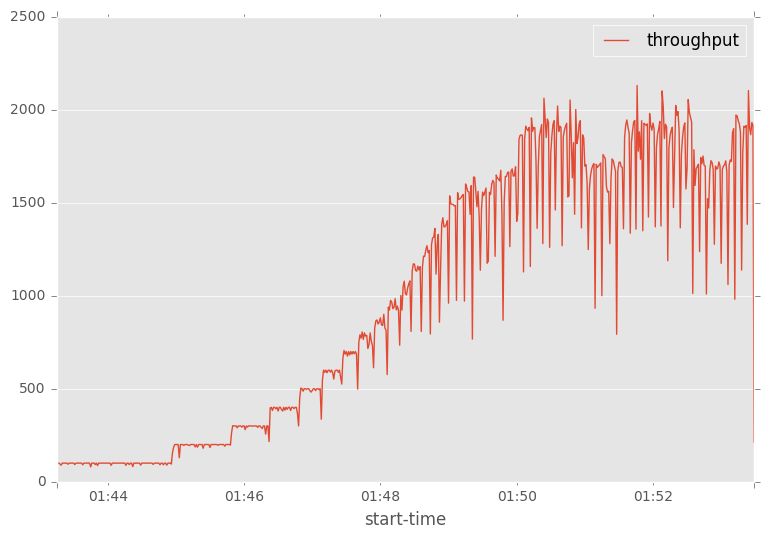

In [28]:
fix, ax = plt.subplots()
ax = throughputDataset.plot(ax=ax, y='throughput')
plt.show()

## Headroom plot

In [29]:
goBinned = throughputBucket.aggregate({'throughput': 'count', 'mean-latency': 'mean'})
goData['throughput'] = throughputBucket.transform(len).reset_index()['response-time']

numFirstSecRequests = goBinned['throughput'].iloc[0]
numLastSecRequests = goBinned['throughput'].iloc[-1]
goData = goData[numFirstSecRequests:-numLastSecRequests]
goData.columns = ['start-time', 'latency', 'throughput']

In [40]:
y, x = dmatrices('latency ~ throughput', data=goData, return_type='dataframe')
fit = sm.GLM(y, x, family=sm.families.InverseGaussian(sm.families.links.inverse_squared)).fit()

goData['fitted'] = fit.fittedvalues
goFitLine = goData.groupby('throughput')['fitted'].first()

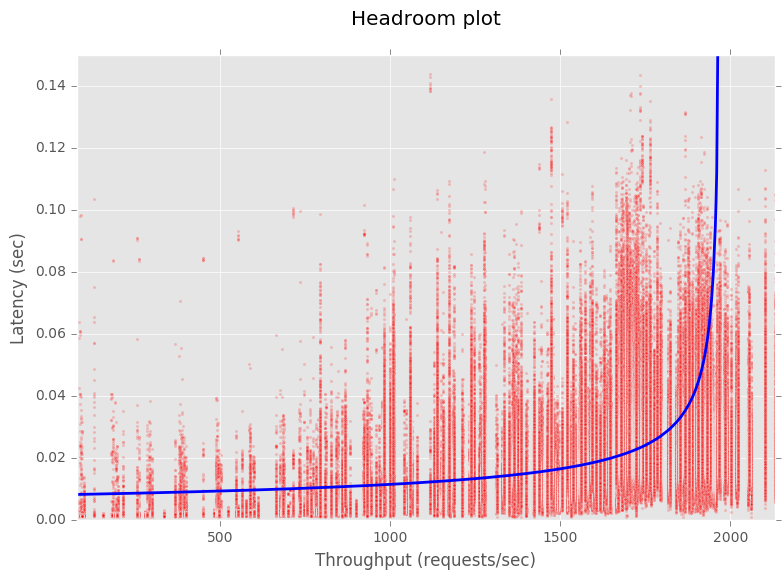

In [38]:
fig, ax = plt.subplots()
ax = goFitLine.plot(ax=ax,x='throughput', y='fitted', c='b', lw=2)
ax = goData.plot(ax=ax, kind='scatter', x='throughput', y='latency', c='r', marker='.', alpha=0.2)
ax.set_ylim(0,0.15)
plt.xlabel('Throughput (requests/sec)')
plt.ylabel('Latency (sec)')
plt.title('Headroom plot', y=1.05)
plt.show()